In [1]:
import pennylane as qml
from pennylane import numpy as np

In [7]:
# ==== Step 1: Cos^{2m}(H) 相关参数 ====
m = 2
k_vals = [-2, -1, 0, 1, 2]
alpha_coeffs = [2**(-2*m) * c for c in [1, 4, 6, 4, 1]]
prep_weights = np.sqrt(alpha_coeffs)
prep_weights /= np.linalg.norm(prep_weights)

# ==== Step 2: TFIM 参数 ====
n_data = 4
J = 1.0
h = 0.7
n_anc = 3   # 编码 5 个 k 值 ⇒ 至少需要 3 位
wires = list(range(n_anc + n_data))
anc_wires = wires[:n_anc]
data_wires = wires[n_anc:]

# ==== TFIM 哈密顿量演化定义 ====
def tfim_evolve(t, wires):
    for i in range(len(wires)-1):
        qml.IsingZZ(-2 * J * t, wires=[wires[i], wires[i+1]])
    for i in range(len(wires)):
        qml.RX(-2 * h * t, wires=wires[i])

# ==== 电路设备 ====
dev = qml.device("default.qubit", wires=wires)

@qml.qnode(dev)
def tfim_cos2m_filter():
    # Step 1: Prepare ancilla superposition √α_k |k⟩
    qml.StatePrep(prep_weights, wires=anc_wires, pad_with=0)

    # Step 2: Apply controlled-e^{2ikH}
    for idx, k in enumerate(k_vals):
        if k == 0:
            continue
        t = abs(2 * k)
        # TFIM evolution for time 2|k|
        def evolve_block():
            tfim_evolve(t, data_wires)
        # 控制在 anc=idx 时调用
        controlled_evolve = qml.ctrl(evolve_block, control=anc_wires, control_values=idx)
        if k > 0:
            controlled_evolve()
        else:
            qml.adjoint(controlled_evolve)()

    # Step 3: 回卷 ancilla
    qml.adjoint(qml.StatePrep)(prep_weights, wires=anc_wires, pad_with=0)

    return qml.state()

# 运行并获取滤波后状态
filtered_state = tfim_cos2m_filter()
print("滤波后全系统量子态：")
print(filtered_state)


滤波后全系统量子态：
[ 9.16272678e-01+0.10572613j -5.30166401e-02-0.04579j
  5.30166401e-02-0.04579j     1.62797121e-02-0.018849j
  5.30166401e-02-0.04579j    -2.10171094e-02+0.01336394j
  1.62797121e-02+0.018849j    6.70138077e-03+0.00578792j
 -5.30166401e-02-0.04579j     1.62797121e-02+0.018849j
 -2.10171094e-02+0.01336394j -6.70138077e-03+0.00578792j
  1.62797121e-02-0.018849j   -6.70138077e-03+0.00578792j
  6.70138077e-03+0.00578792j  2.65659334e-03+0.00168922j
 -1.02544609e-01+0.12948754j -6.49318580e-02-0.05608107j
  6.49318580e-02-0.05608107j  1.99384939e-02-0.02308521j
  6.49318580e-02-0.05608107j -2.57405969e-02+0.01636741j
  1.99384939e-02+0.02308521j  8.20748173e-03+0.00708873j
 -6.49318580e-02-0.05608107j  1.99384939e-02+0.02308521j
 -2.57405969e-02+0.01636741j -8.20748173e-03+0.00708873j
  1.99384939e-02-0.02308521j -8.20748173e-03+0.00708873j
  8.20748173e-03+0.00708873j  3.25364907e-03+0.00206887j
 -5.92041575e-02+0.07475967j -3.74884257e-02-0.03237842j
  3.74884257e-02-0.03237842

In [8]:
filtered_state.shape

(128,)

In [23]:
import pennylane as qml

H = -0.4 * qml.Z(0) + 0.3 * qml.Z(1) + 0.4 * qml.Z(0) @ qml.Z(1)

#print(np.linalg.eigvalsh(qml.matrix(H).real)[0])
control_wires = [2, 3]
estimation_wires = [4, 5, 6, 7, 8, 9]

dev = qml.device("default.qubit")


@qml.qnode(dev)
def circuit():
    # Initialize the eigenstate |11⟩
    # for wire in [0, 1]:
    #     qml.X(wire)

    # Apply QPE with the qubitization operator
    qml.QuantumPhaseEstimation(
        qml.Qubitization(H, control_wires), estimation_wires=estimation_wires
    )

    return qml.probs(wires=estimation_wires)

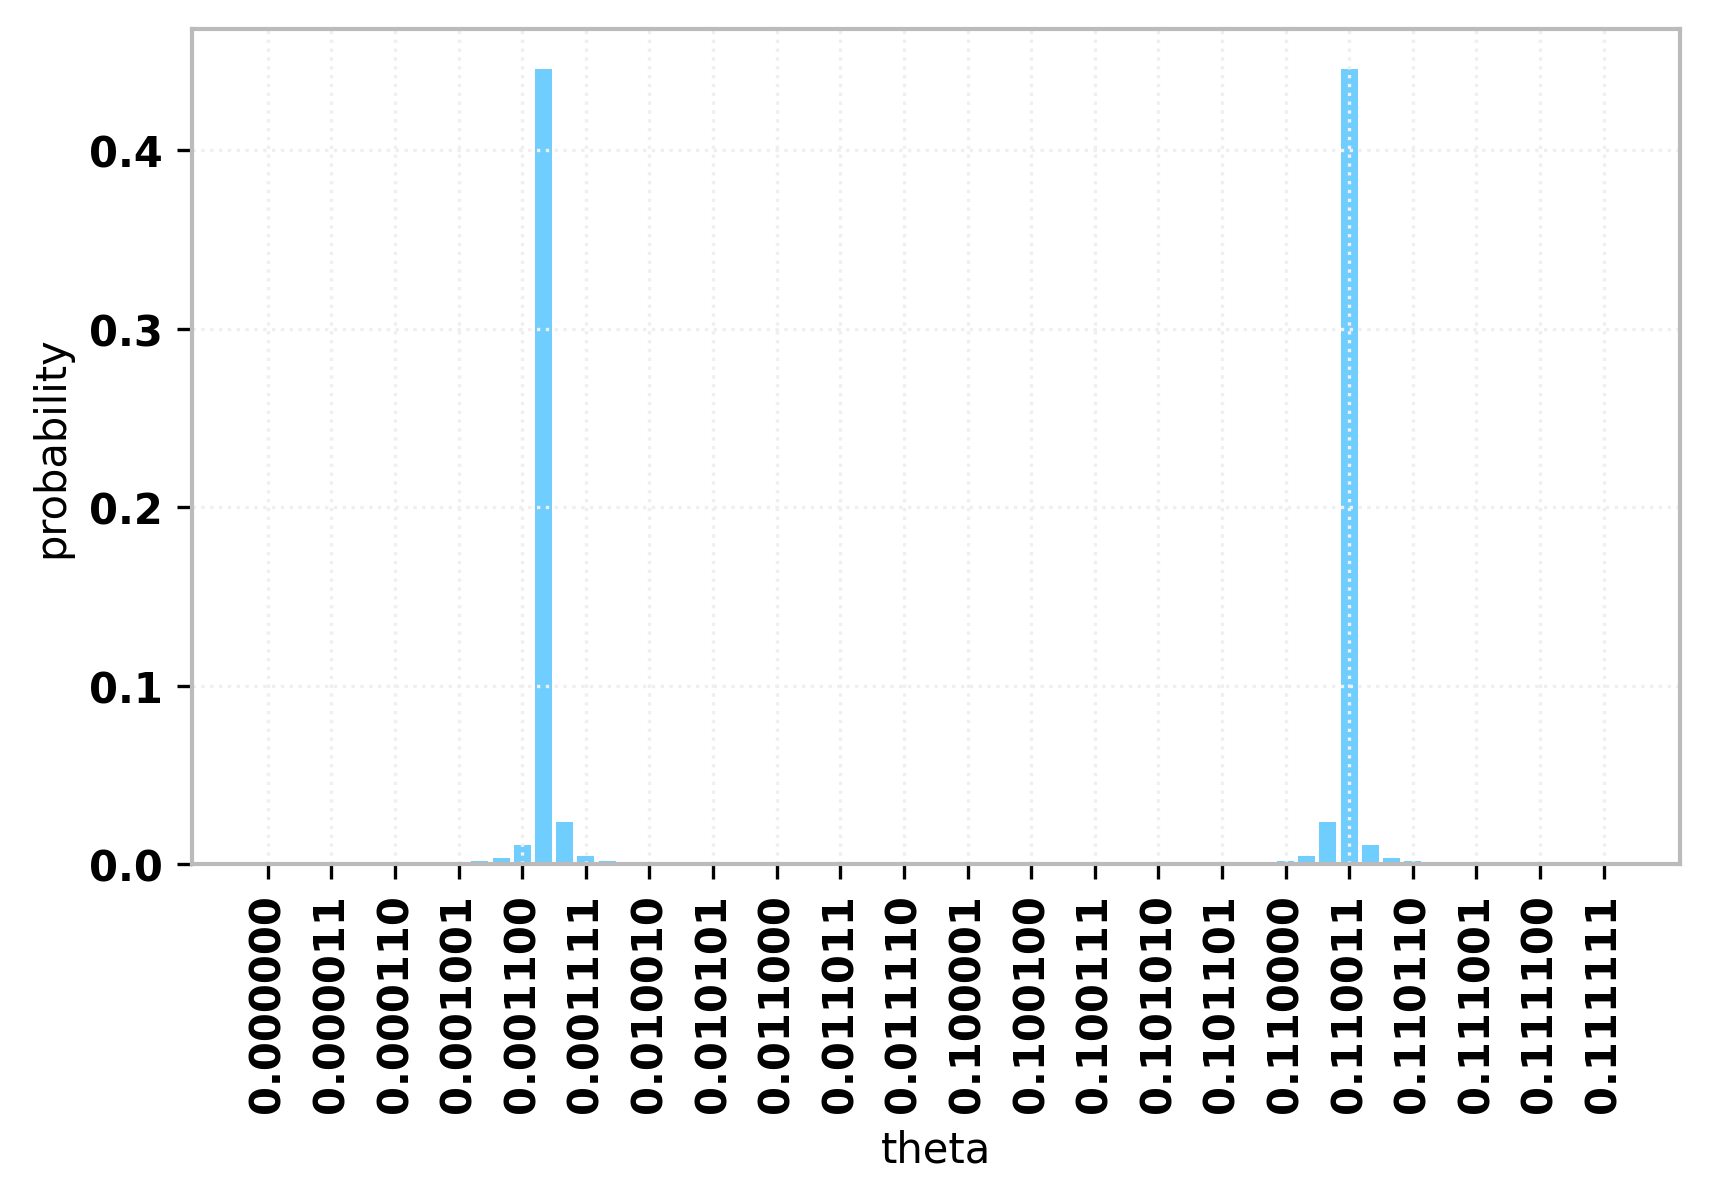

In [24]:
import matplotlib.pyplot as plt

plt.style.use("pennylane.drawer.plot")

results = circuit()

bit_strings = [f"0.{x:0{len(estimation_wires)}b}" for x in range(len(results))]

plt.bar(bit_strings, results)
plt.xlabel("theta")
plt.ylabel("probability")
plt.xticks(range(0, len(results), 3), bit_strings[::3], rotation="vertical")

plt.subplots_adjust(bottom=0.3)
plt.show()

In [25]:
import numpy as np

lambda_ = sum([abs(coeff) for coeff in H.terms()[0]])

# Simplification by estimating theta with the peak value
print("E = ", lambda_ * np.cos(2 * np.pi * np.argmax(results) / 2 ** (len(estimation_wires))))

E =  0.3193131449799086


In [33]:
import pennylane as qml
from pennylane import numpy as np
import math  # ✅ 引入标准 math
import numpy as onp  # ✅ onp 是普通 numpy，用于控制组合数运算
# === Hamiltonian H (TFIM with 4 qubits) ===
n_qubits = 4
J = 1.0
h = 1.0
coeffs, ops = [], []
for i in range(n_qubits - 1):
    coeffs.append(J)
    ops.append(qml.PauliZ(i) @ qml.PauliZ(i + 1))
for i in range(n_qubits):
    coeffs.append(h)
    ops.append(qml.PauliX(i))
H = qml.Hamiltonian(coeffs, ops)

# === cos^{2m}(H) setup ===
m = 2
k_vals = np.arange(-m, m + 1)
alpha_k = 2**(-2*m) * onp.array([math.comb(2*m, m + k) for k in k_vals])
prep_weights = np.sqrt(alpha_k) / np.linalg.norm(np.sqrt(alpha_k))

n_anc = int(np.ceil(np.log2(len(k_vals))))
total_wires = n_anc + n_qubits
anc_wires = list(range(n_anc))
data_wires = list(range(n_anc, total_wires))

dev = qml.device("default.qubit", wires=total_wires)

@qml.qnode(dev)
def cos2m_filter():
    qml.StatePrep(prep_weights, wires=anc_wires, pad_with=0)
    for idx, k in enumerate(k_vals):
        if k == 0:
            continue
        def evolution():
            qml.templates.ApproxTimeEvolution(H, time=2 * abs(k), n=1)
        ctrl = qml.ctrl(evolution, control=anc_wires, control_values=idx)
        if k > 0:
            ctrl()
        else:
            qml.adjoint(ctrl)()
    qml.adjoint(qml.StatePrep)(prep_weights, wires=anc_wires, pad_with=0)
    return qml.state()

# Run circuit and extract filtered subspace
state = cos2m_filter()
data_state = reduce_statevector(state, indices=data_wires, wires_that_are_0=anc_wires)
normalized = data_state / np.linalg.norm(data_state)

# Measure energy
energy = qml.expval(H)(normalized)
print("估计基态能量 ≈", energy)


ValueError: control_values should be the same length as control_wires